# Load modules

In [1]:
import glob
import os
import math
import joblib
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

print(os.listdir('../../../data/wine_quality/raw/'))

['winequality-red.csv', 'winequality.names', 'red_white_wine_quality.pickle', 'wine_quality.csv', 'winequality-white.csv']


# Load data

In [2]:
filename = '../../../data/wine_quality/raw/red_white_wine_quality.pickle'
df = joblib.load(filename)
df.head(3)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   

   free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   

   alcohol  quality wine_type  
0      8.8        6     white  
1      9.5        6     white  
2     10.1        6     white

# EDA

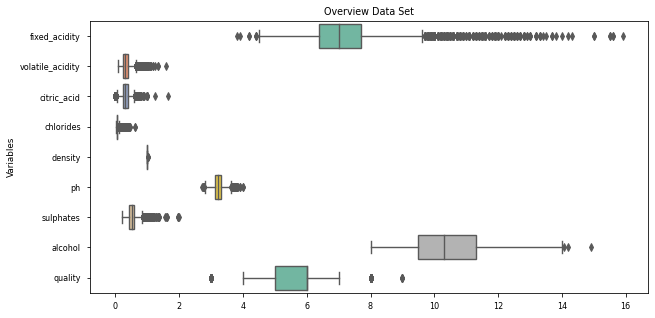

In [3]:
plt_style = 'seaborn-paper' # or seaborn-paper, ggplot, fivethirtyeight
plt.style.use(plt_style) 

f, ax = plt.subplots(figsize = (10,5))

# ax.set_facecolor('#fafafa') 
# ax.set(xlim = (0, 16)) # X축 범위
plt.ylabel('Variables') # Y축 이름
plt.title("Overview Data Set")

ax = sns.boxplot(data = df.drop(['free_sulfur_dioxide','total_sulfur_dioxide','residual_sugar'], axis=1),                 
                 orient = 'h', 
                 palette = 'Set2'
                )

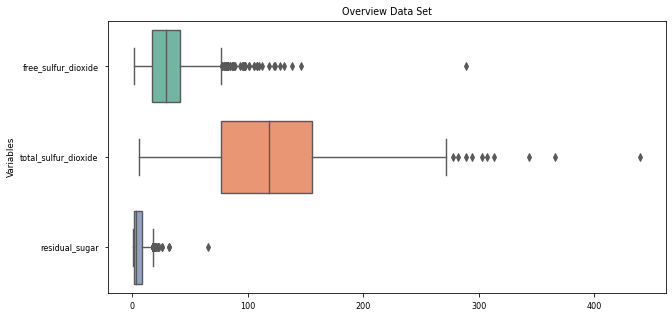

In [4]:
plt.style.use(plt_style) 

f, ax = plt.subplots(figsize = (10,5))

# ax.set_facecolor('#fafafa') 
# ax.set(xlim = (0, 16)) # X축 범위
plt.ylabel('Variables') # Y축 이름
plt.title("Overview Data Set")

ax = sns.boxplot(data = df[['free_sulfur_dioxide','total_sulfur_dioxide','residual_sugar']],                 
                 orient = 'h', 
                 palette = 'Set2'
                )

wine_type                 index   red  white
0                 fixed_acidity  8.32   6.85
1              volatile_acidity  0.53   0.28
2                   citric_acid  0.27   0.33
3                residual_sugar  2.54   6.39
4                     chlorides  0.09   0.05
5           free_sulfur_dioxide 15.87  35.31
6          total_sulfur_dioxide 46.47 138.36
7                       density  1.00   0.99
8                            ph  3.31   3.19
9                     sulphates  0.66   0.49
10                      alcohol 10.42  10.51
11                      quality  5.64   5.88

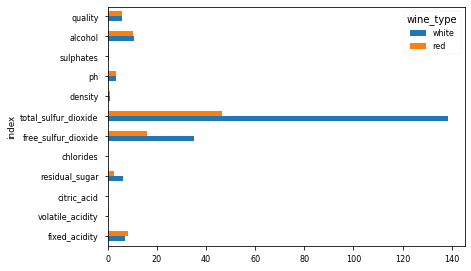

In [8]:
pd.options.display.float_format = "{:,.2f}".format

summary_df = df.groupby('wine_type').mean().T
summary_df.reset_index(level=0, inplace=True)
display(summary_df)

summary_df.plot(x='index', y=['white','red'], kind="barh")

In [6]:
df[df['wine_type']=='red'].groupby('quality').mean().T

quality                  3     4     5     6     7     8
fixed_acidity         8.36  7.78  8.17  8.35  8.87  8.57
volatile_acidity      0.88  0.69  0.58  0.50  0.40  0.42
citric_acid           0.17  0.17  0.24  0.27  0.38  0.39
residual_sugar        2.64  2.69  2.53  2.48  2.72  2.58
chlorides             0.12  0.09  0.09  0.08  0.08  0.07
free_sulfur_dioxide  11.00 12.26 16.98 15.71 14.05 13.28
total_sulfur_dioxide 24.90 36.25 56.51 40.87 35.02 33.44
density               1.00  1.00  1.00  1.00  1.00  1.00
ph                    3.40  3.38  3.30  3.32  3.29  3.27
sulphates             0.57  0.60  0.62  0.68  0.74  0.77
alcohol               9.96 10.27  9.90 10.63 11.47 12.09

In [7]:
df[df['wine_type']=='white'].groupby('quality').mean().T

quality                   3      4      5      6      7      8      9
fixed_acidity          7.60   7.13   6.93   6.84   6.73   6.66   7.42
volatile_acidity       0.33   0.38   0.30   0.26   0.26   0.28   0.30
citric_acid            0.34   0.30   0.34   0.34   0.33   0.33   0.39
residual_sugar         6.39   4.63   7.33   6.44   5.19   5.67   4.12
chlorides              0.05   0.05   0.05   0.05   0.04   0.04   0.03
free_sulfur_dioxide   53.33  23.36  36.43  35.65  34.13  36.72  33.40
total_sulfur_dioxide 170.60 125.28 150.90 137.05 125.11 126.17 116.00
density                0.99   0.99   1.00   0.99   0.99   0.99   0.99
ph                     3.19   3.18   3.17   3.19   3.21   3.22   3.31
sulphates              0.47   0.48   0.48   0.49   0.50   0.49   0.47
alcohol               10.35  10.15   9.81  10.58  11.37  11.64  12.18

# Profiling

In [9]:
from pandas_profiling import ProfileReport

In [11]:
profile = ProfileReport(df, 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile.html")